In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from sklearn.cluster import KMeans
from pandas import ExcelWriter

fn_E = "Main_Input_Ericsson.csv"
Main_Input_Ericsson = pd.read_csv(fn_E)

fn_N = "Main_Input_Nokia.csv"
Main_Input_Nokia = pd.read_csv(fn_N)

fn_H = "Main_Input_Huawei.csv"
Main_Input_Huawei = pd.read_csv(fn_H)

print(Main_Input_Ericsson.columns)
print(Main_Input_Nokia.columns)
print(Main_Input_Huawei.columns)

Index(['Date', 'ElementID', 'ElementID1',
       'Average_RRC_Connected_Users(EUCell_Eric)',
       'Total_Volume(UL+DL)(GB)(EUCell_Eric)',
       'Total_DL_Volume(GB)(EUCell_Eric)',
       'Average_UE_DL_Throughput(Mbps)(EUCell_Eric)',
       'Average_PDCP_Cell_Dl_Throughput(Mbps)(EUCell_Eric)',
       'CQI_(EUCell_Eric)'],
      dtype='object')
Index(['Date', 'ElementID', 'ElementID1',
       'Average_RRC_Connected_UEs(Nokia_LTE_CELL)',
       'Average_RRC_Connected_UEs_S17(Nokia_LTE_CELL)',
       'Payload_DL_GB(Nokia_LTE_CELL)', 'Total_Payload_GB(Nokia_LTE_CELL)',
       'User_Throughput_DL_mbps(Nokia_LTE_CELL)',
       'PDCP_Layer_Active_Cell_Throughput_DL_mbps(Nokia_LTE_CELL)',
       'Average_CQI(Nokia_LTE_CELL)'],
      dtype='object')
Index(['Date', 'ElementID', 'ElementID1', 'Avarage_number_of_users_in_a_cell',
       'DL_Traffic(GB)', 'Total_Traffic(GB)(Hu_Cell)',
       'Average_Downlink_User_Throughput(Mbit/s)(Hu_Cell)',
       'Downlink_Cell_Throghput(Mbit/s)(Hu_Cell)',
 

### KPI Title Mapping

In [2]:
# Ericsson
eric_dict = {'Date' : 'Date', 'ElementID' : 'Prov', 'ElementID1' : 'Cell',
       'Average_RRC_Connected_Users(EUCell_Eric)' : 'Conn_User',
       'Total_Volume(UL+DL)(GB)(EUCell_Eric)' : 'Total_Payload',
       'Total_DL_Volume(GB)(EUCell_Eric)' : 'DL_Payload',
       'Average_UE_DL_Throughput(Mbps)(EUCell_Eric)' : 'User_Throughput' , 
        'Average_PDCP_Cell_Dl_Throughput(Mbps)(EUCell_Eric)' : 'Cell_Throughput' , 
             'CQI_(EUCell_Eric)' : 'CQI'}

vals = Main_Input_Ericsson.columns

Main_Input_Ericsson.columns = [eric_dict[val] for val in vals]

# Huawei
hua_dict = {'Date' : 'Date', 'ElementID' : 'Prov', 'ElementID1' : 'Cell',
       'Avarage_number_of_users_in_a_cell' : 'Conn_User',
       'Total_Traffic(GB)(Hu_Cell)' : 'Total_Payload',
       'DL_Traffic(GB)' : 'DL_Payload',
       'Average_Downlink_User_Throughput(Mbit/s)(Hu_Cell)' : 'User_Throughput' , 
        'Downlink_Cell_Throghput(Mbit/s)(Hu_Cell)' : 'Cell_Throughput' , 
             'Average_CQI(Huawei_LTE_Cell)' : 'CQI'}

vals = Main_Input_Huawei.columns

Main_Input_Huawei.columns = [hua_dict[val] for val in vals]

# Nokia Conn_Users Coloumn :
Main_Input_Nokia.fillna(value=0,inplace=True)
Main_Input_Nokia['New_Coloumn_RRC_Connected_UEs'] = Main_Input_Nokia['Average_RRC_Connected_UEs(Nokia_LTE_CELL)'] + Main_Input_Nokia['Average_RRC_Connected_UEs_S17(Nokia_LTE_CELL)']
Main_Input_Nokia.drop(['Average_RRC_Connected_UEs(Nokia_LTE_CELL)', 'Average_RRC_Connected_UEs_S17(Nokia_LTE_CELL)'], axis=1, inplace = True)

nokia_dict = {'Date' : 'Date', 'ElementID' : 'Prov', 'ElementID1' : 'Cell',
       'New_Coloumn_RRC_Connected_UEs' : 'Conn_User',
       'Total_Payload_GB(Nokia_LTE_CELL)' : 'Total_Payload',
       'Payload_DL_GB(Nokia_LTE_CELL)' : 'DL_Payload',
       'User_Throughput_DL_mbps(Nokia_LTE_CELL)' : 'User_Throughput' , 
        'PDCP_Layer_Active_Cell_Throughput_DL_mbps(Nokia_LTE_CELL)' : 'Cell_Throughput' , 
             'Average_CQI(Nokia_LTE_CELL)' : 'CQI'}

vals = Main_Input_Nokia.columns

Main_Input_Nokia.columns = [nokia_dict[val] for val in vals]

#print(eric_dict)



In [59]:
#Main_Input_Network = Main_Input_Ericsson.copy()
#Main_Input_Network = Main_Input_Huawei.copy()
#Main_Input_Network = Main_Input_Nokia.copy()


Main_Input_Network = pd.concat([Main_Input_Ericsson, Main_Input_Nokia, Main_Input_Huawei], axis = 0, sort=False)

### Aggregation

In [60]:
#import time
# create sector ID

#t = time.time()

Main_Input_Network['Sector'] = Main_Input_Network['Cell']
Main_Input_Network.Sector = Main_Input_Network.Cell.str.slice(0, 2) + Main_Input_Network.Cell.str.slice(4, 9)

data_den = Main_Input_Network.groupby(['Prov','Sector','Date'])['Conn_User',
       'Total_Payload', 'DL_Payload', 'Cell_Throughput'].agg(sum)

data_mult = pd.DataFrame()
#data_mult['CDT'] = Main_Input_Network['Cell_Throughput']* Main_Input_Network['DL_Payload']
data_mult['CQIT'] = Main_Input_Network['CQI']* Main_Input_Network['DL_Payload']
data_mult['UDT'] = Main_Input_Network['User_Throughput'] * Main_Input_Network['Conn_User']
data_mult['Date'] = Main_Input_Network['Date']
data_mult['Sector'] = Main_Input_Network['Sector']
data_mult['Prov'] = Main_Input_Network['Prov']
data_mult_sum = data_mult.groupby(['Prov','Sector', 'Date'])['UDT','CQIT'].agg(sum)

In [61]:
data_merged = pd.concat([ data_mult_sum, data_den], axis = 1, sort=False)

#data_merged['Cell_Throughput'] = data_merged.apply(lambda x: x.CDT / (x.DL_Payload + (x.DL_Payload == 0)), axis=1)
#data_merged['CQI'] = data_merged.apply(lambda x: x.CQIT / (x.DL_Payload + (x.DL_Payload == 0)), axis=1)
#data_merged['User_Throughput'] = data_merged.apply(lambda x: x.UDT / (x.Conn_User + (x.Conn_User == 0)), axis=1)

data_merged['CQI'] = data_merged['CQIT'] / (data_merged['DL_Payload'] + (data_merged['DL_Payload'] == 0))
data_merged['User_Throughput'] = data_merged['UDT'] / (data_merged['Conn_User'] + (data_merged['Conn_User'] == 0))

#data_merged.drop(['CDT','UDT','CQIT'], axis=1, inplace = True)
data_merged.drop(['UDT','CQIT'], axis=1, inplace = True)

data_merged_df = data_merged.reset_index()

#elapsed = time.time() - t
#print(elapsed)
#print(data_merged.head())

### Write excel

In [7]:
from pandas import ExcelWriter

writer = ExcelWriter('Aggregated.xlsx')
data_merged_df.to_excel(writer)
writer.save()

### Replace miss data with the average

In [62]:
yy = data_merged_df.Date.unique()
xx = data_merged_df.Sector.unique()
z = [(x, y) for x in xx for y in yy]
zz = pd.DataFrame(z)
zz.columns = ['Sector','Date']
#dftesty = data_merged_df.copy()
data_merged_df = data_merged_df.merge(zz, left_on= ['Sector','Date'], right_on= ['Sector','Date'], how = 'right')
#dftesty.fillna(dftesty.mean())

#dftesty[dftesty['Sector']=='KM0001A']
#data_merged_df[data_merged_df['Sector']=='KM0001A']
#data_merged_df2 = data_merged_df.reset_index(drop = True)
#data_merged_df2 = data_merged_df.copy()

data_merged_df['Prov'] = data_merged_df.Sector.str.slice(0,2)
data_merged_df.sort_values(['Sector', 'Date'], ascending=[True, True], inplace = True)
data_merged_df = data_merged_df.reset_index(drop = True)
data_merged_df = data_merged_df.fillna(method='ffill')

### Select complete data - no missing

In [63]:
df1 = data_merged_df2[data_merged_df2.Date.groupby(data_merged_df2.Sector).transform('count') % 168 == 0]
#print(df1)
#df1 = df1.drop(['Sector','Date'],axis = 1)
#print(df1.dtypes)
X = df1['Conn_User'].values

### Clustering

1348
2233
3557
677
2772


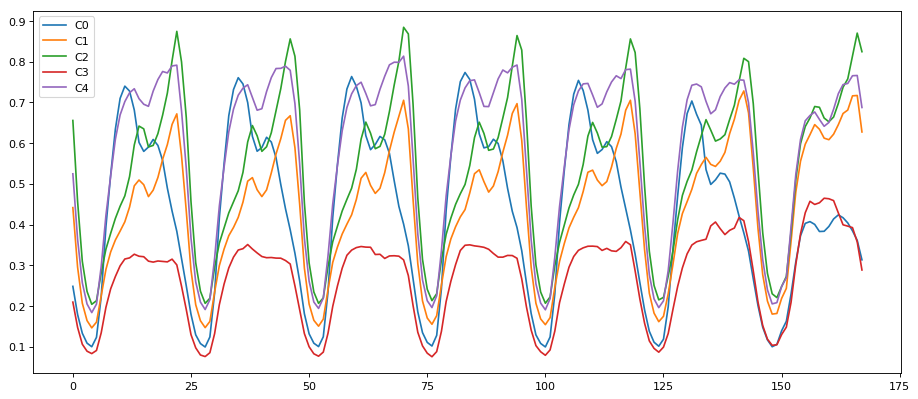

10587
10587


In [64]:
from sklearn.metrics import silhouette_score
import numpy.ma as ma

sector = df1.groupby('Sector')['Date'].count().index.tolist()
x = X.reshape(round(np.size(X)/168),168)

#x = np.where(np.isnan(x), ma.array(x, mask=np.isnan(x)).mean(axis = 0), x)    
#x = np.where(np.isnan(x), ma.array(x, mask=np.isnan(x)).mean(axis=0)[:, np.newaxis], x)

# all zero rows are deleted
xsum = x.sum(axis=1, keepdims=True)
ind_zero_sum = np.argwhere(xsum == 0)
ind_zero_sum = np.unique(ind_zero_sum[:,0])
sector = [sector[i] for i in range(len(sector)) if i not in ind_zero_sum.tolist() ]
x = np.delete(x, ind_zero_sum, axis=0)

# rows with nan values are deleted
ind_nan = np.argwhere(np.isnan(x))
ind_nan = np.unique(ind_nan[:,0])
x = np.delete(x, ind_nan, axis=0)
sector = [ sector[i] for i in range(len(sector)) if i not in ind_nan.tolist() ]

# rows with low number of connected users
xsum = x.sum(axis = 1, keepdims = True)
ind_zero_sum = np.argwhere(xsum < 30)

ind_zero_sum = np.unique(ind_zero_sum[:,0])
#print(len(ind_zero_sum))
sector = [sector[i] for i in range(len(sector)) if i not in ind_zero_sum.tolist() ]
x = np.delete(x, ind_zero_sum, axis=0)
xo = x
# normalise
x = x/x.max(axis=1, keepdims=True)
opt_k = False
if not opt_k:
    nC = 5
    kmeans = KMeans(n_clusters = nC, random_state=0).fit(x)
    kmeans.labels_
    kmeans.cluster_centers_
    #labels = [list(a) for a in zip(Sector, kmeans.labels_.tolist())]


    plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
    for i in range(nC):
        if np.count_nonzero(kmeans.labels_ == i)>50:
            plt.plot(kmeans.cluster_centers_[i,:], label='C' + str(i))
            print(np.count_nonzero(kmeans.labels_ == i))
    plt.legend()
    plt.show()

    #create new df 
    print(len(sector))
    print(len(kmeans.labels_.tolist()))
    df = pd.DataFrame({'Sector':sector, 'Labels': kmeans.labels_.tolist()})
    writer = ExcelWriter('temp_Labels' + str(nC) + '.xlsx')
    df.to_excel(writer, index=False)
    writer.save()
else:
    range_n_clusters = [3, 4, 5, 6]

    for nC in range_n_clusters:
   
        kmeans = KMeans(n_clusters = nC, random_state=0).fit(x)
        cluster_labels = kmeans.fit_predict(x)
        silhouette_avg = silhouette_score(x, cluster_labels)
        print('For n_clusters =', nC,
              'The average silhouette_score is :', silhouette_avg)

In [ ]:
'''
plt.plot(x[10021,:], label='normalized')
#plt.plot(xo[10021,:], label='original')
plt.legend()
'''

In [10]:
#np.where(np.array(sector) =='QM0155A')

(array([], dtype=int64),)

### Load BW of each Sector

In [66]:
fn_DB = "LTE_DB.xlsx"
BW_DB = pd.read_excel(fn_DB, sheet_name = 'Sector_BW_DB')

### First Peak

In [67]:
df1argmax = data_merged_df.groupby('Sector', as_index=False).apply(lambda x: x.loc[x.Conn_User.idxmax(),])
df1argmax.head()

,Prov,Sector,Date,Conn_User,Total_Payload,DL_Payload,Cell_Throughput,CQI,User_Throughput
0,2L,2L03B1,2019-02-23 22:00:00,52.038,5.354,4.895,17.103,9.319000,11.589000
1,AG,AG0001A,2019-02-25 23:00:00,25.571,2.175,1.860,13.582,9.043000,14.288000
2,AG,AG0001B,2019-02-24 23:00:00,34.049,3.851,3.344,12.316,7.342000,5.759000
3,AG,AG0001C,2019-03-01 13:00:00,47.880,4.100,3.609,17.987,9.939000,14.098000
4,AG,AG0002A,2019-02-25 11:00:00,56.545,2.959,2.640,27.236,8.922973,10.069938


### Join BW with First Peak data

In [68]:
#df1argmax = df1argmax.reset_index(drop=True)
common_column = 'Sector'
df1argmax = pd.merge(df1argmax, BW_DB[['Sector','Sector_BW']], left_on = common_column, right_on = common_column)


In [161]:
# Join Prov (old code !!)
#common_column = ['Sector','Date']
#df1argmax = pd.merge(df1argmax, Main_Input_Network[['Date','Sector','Prov']] , left_on = common_column, right_on = common_column)

In [27]:
# Replace Nans with 15 (old code !!)
# df1argmax['Sector_BW'][df1argmax['Sector_BW'].isnull()] = 15

C:\Users\Saeed\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Capacity Estimation

In [111]:
df1argmax['Spectral_Efficiency'] = df1argmax.Cell_Throughput/df1argmax.Sector_BW
df1argmax['Capacity_GB'] = df1argmax['Spectral_Efficiency'] * df1argmax['Sector_BW'] * 3600 / 8000
df1argmax['Usage'] = df1argmax['DL_Payload'] /(df1argmax['Capacity_GB']+ (df1argmax['Capacity_GB'] == 0))*100
#df1argmax

### Province Capacity Estimation

In [112]:
Capacity = df1argmax.groupby('Prov', as_index = False)['Total_Payload','DL_Payload','Capacity_GB','Sector_BW'].sum()
Capacity_s = df1argmax.groupby('Prov', as_index = False)['Sector'].count()
Capacity = pd.merge(Capacity, Capacity_s, left_on = 'Prov', right_on = 'Prov')

### Utilization versus Throughput

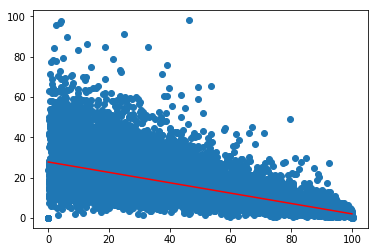

In [116]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
#np.isnan(df1argmax['Usage'].values.all())
#np.where(df1argmax['Usage'].values >= 102)#np.finfo(np.float64).max)
xtr = df1argmax['Usage'].values.reshape(-1, 1)
ytr = df1argmax['User_Throughput'].values.reshape(-1, 1)
model.fit(xtr, ytr)
xfit = np.linspace(0, 100, 100)
yfit = model.predict(xfit[:, np.newaxis])

# plot
plt.scatter(df1argmax['Usage'], df1argmax['User_Throughput'])
plt.plot(xfit, yfit, 'r-');

### To excel

In [64]:
writer = ExcelWriter('Province_Sector.xlsx')
df1argmax.to_excel(writer)
writer.save()

In [152]:
Main_Input_Network.columns

Index(['Date', 'Prov', 'Cell', 'Conn_User', 'Total_Payload', 'DL_Payload',
       'User_Throughput', 'Cell_Throughput', 'CQI', 'Sector'],
      dtype='object')

In [63]:
writer = ExcelWriter('Province_Capacity.xlsx')
Capacity.to_excel(writer)
writer.save()

### Second peak

In [79]:
df1arg2ndmax = data_merged_df.groupby('Sector').apply(lambda x:x.nlargest(2,'Conn_User').iloc[1]).reset_index(drop=True)
df1arg2ndmax.head()

,Prov,Sector,Date,Conn_User,Total_Payload,DL_Payload,Cell_Throughput,CQI,User_Throughput
0,SB,2L03B1,2019-02-23 21:00:00,49.643,3.646,3.277,12.910,9.388000,10.668000
1,AG,AG0001A,2019-02-26 22:00:00,23.929,3.314,2.979,18.141,8.954000,16.160000
2,AG,AG0001B,2019-02-25 23:00:00,33.629,3.296,2.847,11.655,7.847000,6.332000
3,AG,AG0001C,2019-02-25 15:00:00,46.078,2.392,2.118,17.548,9.395000,22.330000
4,AG,AG0002A,2019-02-23 11:00:00,56.082,2.715,2.379,23.652,9.323078,8.287615


### Capacity Estimation based on second peak

In [80]:
# Sector_BW
common_column = 'Sector'
df1arg2ndmax = pd.merge(df1arg2ndmax, BW_DB[['Sector','Sector_BW']], left_on = common_column, right_on = common_column)

# Replace Nans with 15
df1arg2ndmax['Sector_BW'][df1arg2ndmax['Sector_BW'].isnull()] = 15

# Capacity Estimation
df1arg2ndmax['Spectral_Efficiency'] = df1arg2ndmax.Cell_Throughput/df1arg2ndmax.Sector_BW
df1arg2ndmax['Capacity_GB'] = df1arg2ndmax['Spectral_Efficiency'] * df1arg2ndmax['Sector_BW'] * 3600 / 8000

# Province Capacity Estimation
Capacity2 = df1arg2ndmax.groupby('Prov', as_index = False)['Total_Payload','DL_Payload','Capacity_GB','Sector_BW'].sum()
Capacity_s = df1arg2ndmax.groupby('Prov', as_index = False)['Sector'].count()
Capacity2 = pd.merge(Capacity2, Capacity_s, left_on = 'Prov', right_on = 'Prov')


C:\Users\Saeed\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Write to excel

In [82]:
writer = ExcelWriter('Province_Sector2.xlsx')
df1arg2ndmax.to_excel(writer)
writer.save()

writer = ExcelWriter('Province_Capacity2.xlsx')
Capacity2.to_excel(writer)
writer.save()